### `tsfresh` is a Python library used for automated feature generation and selection using time series data.

This notebook demonstrates 

1. how `tsfresh` can be used to automatically generate 700+ features from time series data
2. how to control list of features to be generated
3. how to generate rolling features

In [1]:
import glob

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pd.options.display.max_rows = 1000

# Read Data

#### Description of the Data

Data used in this notebook is from the Kaggle Competition "INGV - Volcanic Eruption Prediction"(https://www.kaggle.com/c/predict-volcanic-eruptions-ingv-oe).

We will explore a bunch of files under `train` and `test` directories. Each file contains **ten minutes of logs from ten different sensors placed around a volcano**. There are 4432 data files under the train directory and 4521 files under test directory. Each of these files consists of 60K lines. On the disk, size of the files under train and test directory is 30G (15G + 15G).

In [2]:
# Location of the data
DATA_DIR = "/opt/vssexclude/personal/kaggle/volcano/data/raw/train"

# Define the datatypes for different sensor data
data_types = {"sensor_1" : np.float32, 
                 "sensor_2" : np.float32, 
                 "sensor_3" : np.float32,
                 "sensor_4" : np.float32,
                 "sensor_5" : np.float32,
                 "sensor_6" : np.float32,
                 "sensor_7" : np.float32,
                 "sensor_8" : np.float32,
                 "sensor_9" : np.float32,
                 "sensor_10" : np.float32}

In [3]:
! ls {DATA_DIR} | wc -l

4431


#### Read data for one CSV file (segment)

In [4]:
df_sample = pd.read_csv(f"{DATA_DIR}/1405189645.csv")
df_sample.head()

,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,sensor_6,sensor_7,sensor_8,sensor_9,sensor_10
0,-361.0,349.0,407.0,-221.0,-13.0,-261.0,-63.0,-317.0,-289.0,969.0
1,-332.0,397.0,463.0,-245.0,-57.0,-237.0,-53.0,-473.0,-318.0,1140.0
2,-333.0,332.0,499.0,-252.0,-115.0,-200.0,-46.0,-508.0,-360.0,1294.0
3,-350.0,174.0,468.0,-240.0,-165.0,-186.0,-39.0,-443.0,-384.0,1434.0
4,-354.0,-4.0,516.0,-207.0,-184.0,-179.0,-43.0,-388.0,-409.0,1548.0


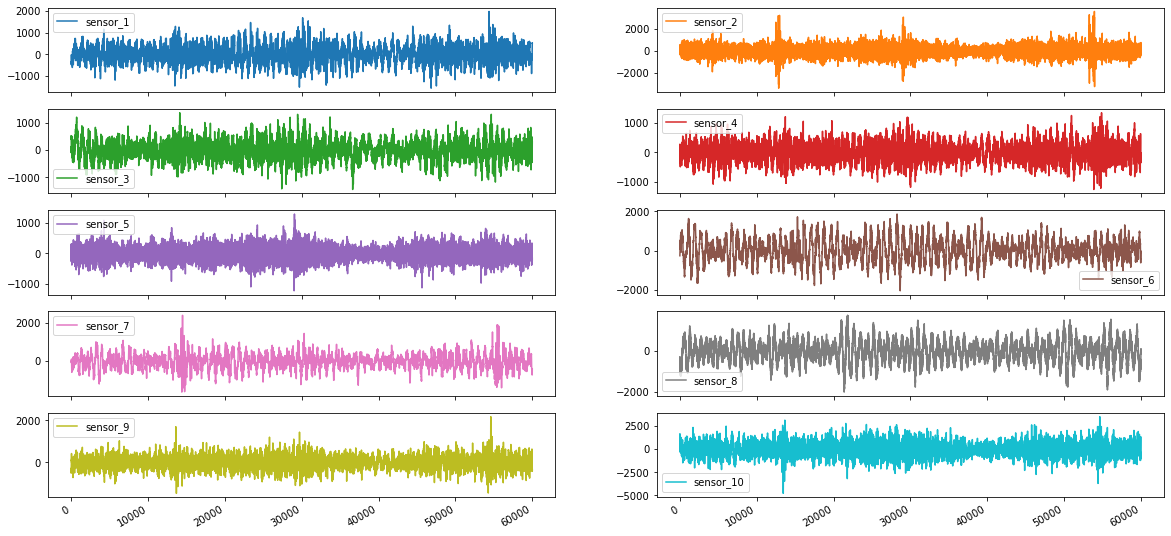

In [5]:
df_sample.plot(subplots=True, layout=(5, 2), figsize=(20, 10))
plt.show()

#### Read all the files using **Pandas**
- Need to do it sequentially
- Memory occupied by the objects must be less than the Main Memory (RAM)

- For simplicity, read first 1000 lines of each file.
- Append the content of each CSV file to one DataFrame
- Add a column named `segment_id` representing the time segment of each CSV file
- Add a column named `time` with ascending values staring from 0 representing time. This column is being used to sort the data w.r.t. time. Without this column, `tsfresh` assumes the data to be already sorted w.r.t. time.

In [9]:
! ls {DATA_DIR}/140*.csv | wc -l

31


In [10]:
df = pd.DataFrame()
for name in glob.glob(f"{DATA_DIR}/140*"):
    temp_df = pd.read_csv(name, dtype=data_types, nrows=1000)
    
    # Extract name of the segment from the file name
    segment_id = int(name.split(".")[0].split("/")[-1])
    temp_df["segment_id"] = segment_id
    print(f"Reading data for segment: {segment_id}")
    
    # Create a column named time
    temp_df["time"] = range(0, len(temp_df))
    
    df = df.append(temp_df)
    
print("\n")    
print(f"Shape of the dataframe consisting of all data from above files: {df.shape}")

Reading data for segment: 1407094442
Reading data for segment: 1405189645
Reading data for segment: 1403440092
Reading data for segment: 1405443107
Reading data for segment: 1400929225
Reading data for segment: 1400727315
Reading data for segment: 1403947680
Reading data for segment: 1400253000
Reading data for segment: 140031872
Reading data for segment: 1409167039
Reading data for segment: 1408663387
Reading data for segment: 1406456924
Reading data for segment: 1404179874
Reading data for segment: 1403005697
Reading data for segment: 1408645616
Reading data for segment: 140851065
Reading data for segment: 140348256
Reading data for segment: 1407261706
Reading data for segment: 1404122310
Reading data for segment: 1404322654
Reading data for segment: 1406938061
Reading data for segment: 1403222059
Reading data for segment: 1402674973
Reading data for segment: 1408285202
Reading data for segment: 1404502479
Reading data for segment: 1402556914
Reading data for segment: 1406626451
Read

In [11]:
df.head()

,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,sensor_6,sensor_7,sensor_8,sensor_9,sensor_10,segment_id,time
0,-580.0,NaN,24.0,-458.0,64.0,-173.0,53.0,NaN,220.0,-301.0,1407094442,0
1,-598.0,NaN,44.0,-432.0,17.0,-724.0,-41.0,NaN,187.0,-320.0,1407094442,1
2,-615.0,NaN,35.0,-342.0,-56.0,-1264.0,-107.0,NaN,179.0,-357.0,1407094442,2
3,-592.0,NaN,43.0,-204.0,-118.0,-1444.0,-143.0,NaN,143.0,-379.0,1407094442,3
4,-536.0,NaN,49.0,-14.0,-147.0,-764.0,-168.0,NaN,106.0,-405.0,1407094442,4


#### For simplicity, we will use the data from 2 sensors

In [12]:
df  = df.loc[:, ["segment_id", "time", "sensor_1", "sensor_4"]]
df.head()

,segment_id,time,sensor_1,sensor_4
0,1407094442,0,-580.0,-458.0
1,1407094442,1,-598.0,-432.0
2,1407094442,2,-615.0,-342.0
3,1407094442,3,-592.0,-204.0
4,1407094442,4,-536.0,-14.0


In [13]:
df.isna().sum()

segment_id    0
time          0
sensor_1      0
sensor_4      0
dtype: int64

# Extract Time Series Features using tsfresh

- Generate features only for time series representing data captured by sensor 1 & 4
- For each time series, `tsfresh` generates ~780 features.

In [14]:
from tsfresh import extract_features
from tsfresh.feature_extraction.settings import ComprehensiveFCParameters

In [16]:
%%time
# Generate features for sensor_1 for each segment_id
extracted_features_df = extract_features(timeseries_container=df, 
                                 default_fc_parameters=ComprehensiveFCParameters(),
                                 column_id="segment_id",
                                 column_sort="time",
                                 n_jobs=10,
                                 disable_progressbar=False
                                )
extracted_features_df = extracted_features_df.rename_axis("segment_id")

Feature Extraction: 100%|██████████| 31/31 [00:14<00:00,  2.11it/s]

CPU times: user 198 ms, sys: 46.1 ms, total: 244 ms
Wall time: 14.9 s


In [19]:
extracted_features_df.shape

(31, 1558)

In [17]:
extracted_features_df.head(3)

,sensor_1__variance_larger_than_standard_deviation,sensor_1__has_duplicate_max,sensor_1__has_duplicate_min,sensor_1__has_duplicate,sensor_1__sum_values,sensor_1__abs_energy,sensor_1__mean_abs_change,sensor_1__mean_change,sensor_1__mean_second_derivative_central,sensor_1__median,...,sensor_4__fourier_entropy__bins_2,sensor_4__fourier_entropy__bins_3,sensor_4__fourier_entropy__bins_5,sensor_4__fourier_entropy__bins_10,sensor_4__fourier_entropy__bins_100,sensor_4__permutation_entropy__dimension_3__tau_1,sensor_4__permutation_entropy__dimension_4__tau_1,sensor_4__permutation_entropy__dimension_5__tau_1,sensor_4__permutation_entropy__dimension_6__tau_1,sensor_4__permutation_entropy__dimension_7__tau_1
segment_id,,,,,,,,,,,,,,,,,,,,,
140031872,1.0,0.0,0.0,1.0,-54490.0,47882792.0,25.139139,0.024024,-0.001503,-43.0,...,0.079983,0.217718,0.376590,0.604455,1.128716,1.282814,1.941725,2.624954,3.290594,3.948798
140348256,1.0,0.0,0.0,1.0,-12608.0,64050948.0,26.994995,-0.346346,-0.014028,4.5,...,0.188113,0.341424,0.500208,0.651610,1.306434,1.511587,2.467225,3.460273,4.373737,5.122356
140851065,1.0,1.0,0.0,1.0,-3568.0,306786560.0,61.619621,-1.369369,0.037074,11.0,...,0.110453,0.220352,0.249958,0.446547,0.804609,1.065453,1.467375,1.898141,2.319963,2.742632


#### What just happened
- `tsfresh` created a single row for each `segement_id`.
- Each row consists of features for both the sensors (named accordingly)

In [25]:
[name for name in extracted_features_df.columns if "sensor_1" in name]

['sensor_1__variance_larger_than_standard_deviation',
 'sensor_1__has_duplicate_max',
 'sensor_1__has_duplicate_min',
 'sensor_1__has_duplicate',
 'sensor_1__sum_values',
 'sensor_1__abs_energy',
 'sensor_1__mean_abs_change',
 'sensor_1__mean_change',
 'sensor_1__mean_second_derivative_central',
 'sensor_1__median',
 'sensor_1__mean',
 'sensor_1__length',
 'sensor_1__standard_deviation',
 'sensor_1__variation_coefficient',
 'sensor_1__variance',
 'sensor_1__skewness',
 'sensor_1__kurtosis',
 'sensor_1__absolute_sum_of_changes',
 'sensor_1__longest_strike_below_mean',
 'sensor_1__longest_strike_above_mean',
 'sensor_1__count_above_mean',
 'sensor_1__count_below_mean',
 'sensor_1__last_location_of_maximum',
 'sensor_1__first_location_of_maximum',
 'sensor_1__last_location_of_minimum',
 'sensor_1__first_location_of_minimum',
 'sensor_1__percentage_of_reoccurring_values_to_all_values',
 'sensor_1__percentage_of_reoccurring_datapoints_to_all_datapoints',
 'sensor_1__sum_of_reoccurring_value

# Control features to be generated

List of features to be calculated is controlled by a dictionary containing a mapping between name of the feature calculators and their parameters. 

There are multiple out of the box dictionaries defined in `tsfresh`:
- MinimalFCParameters
- ComprehensiveFCParameters
- EfficientFCParameters

#### `MinimalFCParameters`

Very minimum set of features can be computed using this configuration. Mostly used while testing/debugging the data pipeline 

In [33]:
from tsfresh.feature_extraction.settings import MinimalFCParameters

minimal = MinimalFCParameters()
minimal

{'sum_values': None,
 'median': None,
 'mean': None,
 'length': None,
 'standard_deviation': None,
 'variance': None,
 'maximum': None,
 'minimum': None}

##### Observations
- Each key represents a feature calculator. 
- Value are the parameters accepted by the feature calculator. 
- If a feature calculator doesn't have parameters, value equals to `None`.

#### Other Feature Calculators
- **ComprehensiveFCParameters** : Computes **all** features available. Takes the longest.
- **EfficientFCParameters**: Computes **most** of the features **fast**.

In [29]:
from tsfresh.feature_extraction.settings import ComprehensiveFCParameters, EfficientFCParameters

comprehensive = ComprehensiveFCParameters()
efficient = EfficientFCParameters()
len(efficient), len(comprehensive)

(69, 71)

In [35]:
comprehensive

{'variance_larger_than_standard_deviation': None,
 'has_duplicate_max': None,
 'has_duplicate_min': None,
 'has_duplicate': None,
 'sum_values': None,
 'abs_energy': None,
 'mean_abs_change': None,
 'mean_change': None,
 'mean_second_derivative_central': None,
 'median': None,
 'mean': None,
 'length': None,
 'standard_deviation': None,
 'variation_coefficient': None,
 'variance': None,
 'skewness': None,
 'kurtosis': None,
 'absolute_sum_of_changes': None,
 'longest_strike_below_mean': None,
 'longest_strike_above_mean': None,
 'count_above_mean': None,
 'count_below_mean': None,
 'last_location_of_maximum': None,
 'first_location_of_maximum': None,
 'last_location_of_minimum': None,
 'first_location_of_minimum': None,
 'percentage_of_reoccurring_values_to_all_values': None,
 'percentage_of_reoccurring_datapoints_to_all_datapoints': None,
 'sum_of_reoccurring_values': None,
 'sum_of_reoccurring_data_points': None,
 'ratio_value_number_to_time_series_length': None,
 'sample_entropy': N

### Build Custom Feature Calculator

#### In case, I know the list of features, I want to generate...
- Modify out of box calculators
- Define your own calculator

#### Modify out of box calculators

In [31]:
len(comprehensive)

71

In [38]:
parameters_to_be_removed = ["symmetry_looking", "large_standard_deviation"]

for name in parameters_to_be_removed:
    del comprehensive[name]
    
len(comprehensive)

69

#### Define your own calculator

In [40]:
 my_fc = {
     'length': None,
     'standard_deviation': None,
     'variance': None,
     'maximum': None,
     'minimum': None,
     'quantile': [
         {'q': 0.1},
         {'q': 0.2}
     ] 
 }

In [41]:
# Generate features for sensor_1 for each segment_id
temp = extract_features(timeseries_container=df, 
                                 default_fc_parameters=my_fc,
                                 column_id="segment_id",
                                 column_sort="time",
                                 n_jobs=10,
                                 disable_progressbar=False
                                )

Feature Extraction: 100%|██████████| 31/31 [00:00<00:00, 566.04it/s]


In [43]:
temp.columns

Index(['sensor_1__length', 'sensor_1__standard_deviation',
       'sensor_1__variance', 'sensor_1__maximum', 'sensor_1__minimum',
       'sensor_1__quantile__q_0.1', 'sensor_1__quantile__q_0.2',
       'sensor_4__length', 'sensor_4__standard_deviation',
       'sensor_4__variance', 'sensor_4__maximum', 'sensor_4__minimum',
       'sensor_4__quantile__q_0.1', 'sensor_4__quantile__q_0.2'],
      dtype='object')

# Feature Selection based on Hypothesis Testing

- Based on the value of the target variable, `tsfresh` can select relevant features
- For this volcano dataset, target variable is "time_to_erruption" assocaited with each segment
- `tsfresh` will test relevance of each of these features w.r.t. target variable

#### Load target varaible ("time_to_erruption") to be used for feature selection 

In [44]:
# Read the CSV file containing "time_to_erruption" for each segment
time_to_errupt_df = pd.read_csv(f"{DATA_DIR}/../train.csv")

# Find the time_to_erruption for the segment_ids used for feature extraction
selected_segment_ids = extracted_features_df.index

# Filter out the target for the selected segment_ids
y = time_to_errupt_df[time_to_errupt_df.segment_id.isin(selected_segment_ids)]

# `tsfresh` expects target variable in a Pandas Series format
y_series = pd.Series(data=y.time_to_eruption.values, index=y.segment_id)

#### Impute missing values of generated features (if any)

In [45]:
from tsfresh.utilities.dataframe_functions import impute

extracted_features_df = impute(extracted_features_df)

Take a look of the data

In [46]:
y_series.shape, extracted_features_df.shape

((31,), (31, 1558))

In [47]:
y_series.head()

segment_id
1400253000    22532237
1403440092     4524342
1406626451    24133615
1403005697    35260256
1408645616    22407847
dtype: int64

In [48]:
extracted_features_df.head()

,sensor_1__variance_larger_than_standard_deviation,sensor_1__has_duplicate_max,sensor_1__has_duplicate_min,sensor_1__has_duplicate,sensor_1__sum_values,sensor_1__abs_energy,sensor_1__mean_abs_change,sensor_1__mean_change,sensor_1__mean_second_derivative_central,sensor_1__median,...,sensor_4__fourier_entropy__bins_2,sensor_4__fourier_entropy__bins_3,sensor_4__fourier_entropy__bins_5,sensor_4__fourier_entropy__bins_10,sensor_4__fourier_entropy__bins_100,sensor_4__permutation_entropy__dimension_3__tau_1,sensor_4__permutation_entropy__dimension_4__tau_1,sensor_4__permutation_entropy__dimension_5__tau_1,sensor_4__permutation_entropy__dimension_6__tau_1,sensor_4__permutation_entropy__dimension_7__tau_1
segment_id,,,,,,,,,,,,,,,,,,,,,
140031872,1.0,0.0,0.0,1.0,-54490.0,4.788279e+07,25.139139,0.024024,-0.001503,-43.0,...,0.079983,0.217718,0.376590,0.604455,1.128716,1.282814,1.941725,2.624954,3.290594,3.948798
140348256,1.0,0.0,0.0,1.0,-12608.0,6.405095e+07,26.994995,-0.346346,-0.014028,4.5,...,0.188113,0.341424,0.500208,0.651610,1.306434,1.511587,2.467225,3.460273,4.373737,5.122356
140851065,1.0,1.0,0.0,1.0,-3568.0,3.067866e+08,61.619621,-1.369369,0.037074,11.0,...,0.110453,0.220352,0.249958,0.446547,0.804609,1.065453,1.467375,1.898141,2.319963,2.742632
1400253000,1.0,0.0,0.0,1.0,-5286.0,1.373399e+08,42.240242,-0.014014,0.055611,19.0,...,0.138228,0.138228,0.235155,0.325140,1.109209,1.414590,2.238319,3.114445,3.982191,4.805546
1400727315,1.0,1.0,1.0,1.0,354441.0,1.440664e+11,954.457458,10.207207,-0.476954,976.5,...,0.110453,0.125256,0.245901,0.325140,0.642095,0.994445,1.309224,1.640863,2.002486,2.372683


#### Select relevant features

In [49]:
from tsfresh import select_features

features_filtered_direct = select_features(extracted_features_df, 
                                           y_series, 
                                           n_jobs=10, 
                                           #show_warnings=True, 
                                           ml_task="regression",
                                          )

In [50]:
features_filtered_direct.shape

(31, 0)

# Rolling Features

So far, one set of features have been generated for each time series (one time series -> one row in `extracted_features_df` above)

But depending on the use case, we may need to generate features based on a fixed window size. This is called rolling window.

<img src="../images/rolling.png" width="700" height="150" style="border-style: solid;">

#### Create Rolling Data

In [77]:
from tsfresh.utilities.dataframe_functions import roll_time_series
df_rolled = roll_time_series(df, 
                             max_timeshift=4, 
                             column_id="segment_id", 
                             column_sort="time", 
                             n_jobs=10)

Rolling: 100%|██████████| 50/50 [00:05<00:00,  9.80it/s]


In [78]:
df.shape, df_rolled.shape

((31000, 4), (154690, 5))

In [79]:
df_rolled.head(100)

,segment_id,time,sensor_1,sensor_4,id
9300,140031872,0,-167.0,307.0,"(140031872, 0)"
9331,140031872,0,-167.0,307.0,"(140031872, 1)"
9332,140031872,1,-172.0,319.0,"(140031872, 1)"
9393,140031872,0,-167.0,307.0,"(140031872, 2)"
9394,140031872,1,-172.0,319.0,"(140031872, 2)"
9395,140031872,2,-169.0,276.0,"(140031872, 2)"
9486,140031872,0,-167.0,307.0,"(140031872, 3)"
9487,140031872,1,-172.0,319.0,"(140031872, 3)"
9488,140031872,2,-169.0,276.0,"(140031872, 3)"
9489,140031872,3,-167.0,252.0,"(140031872, 3)"


In [80]:
df_rolled = df_rolled.drop("segment_id", axis="columns")

#### Generate features on the rolling data

In [81]:
from tsfresh import extract_features
from tsfresh.feature_extraction.settings import MinimalFCParameters

# Generate features for sensor_1 for each segment_id
# It's important that we retain the automatically generated columns, sort and id
extracted_rolling_features_df = extract_features(timeseries_container=df_rolled, 
                                 default_fc_parameters=MinimalFCParameters(),
                                 column_id="id",
                                 column_sort="time",
                                 n_jobs=10,
                                 disable_progressbar=False
                                )

Feature Extraction: 100%|██████████| 50/50 [00:15<00:00,  3.15it/s]


In [82]:
extracted_rolling_features_df.shape

(31000, 16)

In [83]:
extracted_rolling_features_df.head(10)

sensor_1__sum_values  sensor_1__median  sensor_1__mean  \
140031872 0                -167.0            -167.0     -167.000000   
          1                -339.0            -169.5     -169.500000   
          2                -508.0            -169.0     -169.333328   
          3                -675.0            -168.0     -168.750000   
          4                -833.0            -167.0     -166.600006   
          5                -805.0            -167.0     -161.000000   
          6                -718.0            -158.0     -143.600006   
          7                -583.0            -139.0     -116.599998   
          8                -369.0             -85.0      -73.800003   
          9                 -68.0             -34.0      -13.600000   

             sensor_1__length  sensor_1__standard_deviation  \
140031872 0               1.0                      0.000000   
          1               2.0                      2.500000   
          2               3.0                      2.054805   
          3               4.0                      2.046338   
          4               5.0                      4.673328   
          5               5.0                     11.949896   
          6               5.0                     31.161516   
          7               5.0                     50.154163   
          8               5.0                     74.354286   
          9               5.0                     99.433601   

             sensor_1__variance  sensor_1__maximum  sensor_1__minimum  \
140031872 0            0.000000             -167.0             -167.0   
          1            6.250000             -167.0             -172.0   
          2            4.222222             -167.0             -172.0   
          3            4.187500             -167.0             -172.0   
          4           21.840000             -158.0             -172.0   
          5          142.800003             -139.0             -172.0   
          6          971.040039              -85.0             -169.0   
          7         2515.439941              -34.0             -167.0   
          8         5528.560059               47.0             -158.0   
          9         9887.041016              143.0             -139.0   

             sensor_4__sum_values  sensor_4__median  sensor_4__mean  \
140031872 0                 307.0             307.0      307.000000   
          1                 626.0             313.0      313.000000   
          2                 902.0             307.0      300.666656   
          3                1154.0             291.5      288.500000   
          4                1399.0             276.0      279.799988   
          5                1332.0             252.0      266.399994   
          6                1304.0             252.0      260.799988   
          7                1374.0             252.0      274.799988   
          8                1517.0             291.0      303.399994   
          9                1664.0             346.0      332.799988   

             sensor_4__length  sensor_4__standard_deviation  \
140031872 0               1.0                      0.000000   
          1               2.0                      6.000000   
          2               3.0                     18.116905   
          3               4.0                     26.272610   
          4               5.0                     29.239700   
          5               5.0                     29.055809   
          6               5.0                     19.507948   
          7               5.0                     39.876812   
          8               5.0                     59.647629   
          9               5.0                     59.844467   

             sensor_4__variance  sensor_4__maximum  sensor_4__minimum  
140031872 0            0.000000              307.0              307.0  
          1           36.000000              319.0              307.0  
          2          328.222229          

In [85]:
extracted_rolling_features_df = extracted_rolling_features_df.droplevel(1, axis=0).rename_axis(["segment_id"]).reset_index()

In [86]:
extracted_rolling_features_df.segment_id.value_counts()

140851065     1000
1406456924    1000
1404122310    1000
1404179874    1000
1403947680    1000
140348256     1000
1407084157    1000
1405189645    1000
1403222059    1000
1403005697    1000
1408663387    1000
1408285202    1000
1403440092    1000
1404322654    1000
1400929225    1000
140031872     1000
1400727315    1000
1408645616    1000
1402556914    1000
1406938061    1000
1405443107    1000
1406234149    1000
1407261706    1000
1409167039    1000
1407094442    1000
1402914692    1000
1400253000    1000
1406626451    1000
1402674973    1000
1404502479    1000
1403244730    1000
Name: segment_id, dtype: int64

In [87]:
extracted_rolling_features_df.head()

,segment_id,sensor_1__sum_values,sensor_1__median,sensor_1__mean,sensor_1__length,sensor_1__standard_deviation,sensor_1__variance,sensor_1__maximum,sensor_1__minimum,sensor_4__sum_values,sensor_4__median,sensor_4__mean,sensor_4__length,sensor_4__standard_deviation,sensor_4__variance,sensor_4__maximum,sensor_4__minimum
0,140031872,-167.0,-167.0,-167.000000,1.0,0.000000,0.000000,-167.0,-167.0,307.0,307.0,307.000000,1.0,0.000000,0.000000,307.0,307.0
1,140031872,-339.0,-169.5,-169.500000,2.0,2.500000,6.250000,-167.0,-172.0,626.0,313.0,313.000000,2.0,6.000000,36.000000,319.0,307.0
2,140031872,-508.0,-169.0,-169.333328,3.0,2.054805,4.222222,-167.0,-172.0,902.0,307.0,300.666656,3.0,18.116905,328.222229,319.0,276.0
3,140031872,-675.0,-168.0,-168.750000,4.0,2.046338,4.187500,-167.0,-172.0,1154.0,291.5,288.500000,4.0,26.272610,690.250000,319.0,252.0
4,140031872,-833.0,-167.0,-166.600006,5.0,4.673328,21.840000,-158.0,-172.0,1399.0,276.0,279.799988,5.0,29.239700,854.960083,319.0,245.0


### References

- [Overview on extracted features](https://tsfresh.readthedocs.io/en/latest/text/list_of_features.html)
- [How to add a custom fetaure](https://tsfresh.readthedocs.io/en/latest/text/how_to_add_custom_feature.html)
- [Example Notebooks](https://github.com/blue-yonder/tsfresh/tree/main/notebooks)
- [Source code for different feature calculators](https://github.com/blue-yonder/tsfresh/blob/9178ef05134f579c1f1cb1310f7af80ad28c321e/tsfresh/feature_extraction/feature_calculators.py)